# Vegetable Classification Using InceptionV3

## Data Loading

In [2]:
# Setup for kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Downloading dataset via Kaggle

!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
 97% 518M/534M [00:02<00:00, 232MB/s]
100% 534M/534M [00:02<00:00, 230MB/s]


In [4]:
# Extracting data from ZipFile

import zipfile
zipfile_ref = zipfile.ZipFile('/content/vegetable-image-dataset.zip','r')
zipfile_ref.extractall('/content')
zipfile_ref.close()

## Data Prepartion

In [25]:
# Improting Necessory Libraries

import os
import cv2
import pathlib
import glob as gb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten,GlobalAveragePooling2D, Dropout

import warnings
warnings.filterwarnings('ignore')

In [14]:
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(category_path, filename))
                    labels.append(category)

    return pd.DataFrame({'filepaths': image_paths, 'labels': labels})

In [17]:
dataset = '/content/Vegetable Images'

train_df = create_dataframe(os.path.join(dataset, "train"))
valid_df = create_dataframe(os.path.join(dataset, "validation"))
test_df = create_dataframe(os.path.join(dataset, "test"))

print(f'Train Dataframe Shape: {train_df.shape}')
print(f'Validation Dataframe Shape: {valid_df.shape}')
print(f'Test Dataframe Shape: {test_df.shape}')

Train Dataframe Shape: (15000, 2)
Validation Dataframe Shape: (3000, 2)
Test Dataframe Shape: (3000, 2)


In [18]:
print(f'Train Dataframe Head: \n{train_df.head()}')
print(f'Validation Dataframe Head: \n{valid_df.head()}')
print(f'Test Dataframe Head: \n{test_df.head()}')

Train Dataframe Head: 
                                           filepaths    labels
0  /content/Vegetable Images/train/Broccoli/0694.jpg  Broccoli
1  /content/Vegetable Images/train/Broccoli/0188.jpg  Broccoli
2  /content/Vegetable Images/train/Broccoli/0402.jpg  Broccoli
3  /content/Vegetable Images/train/Broccoli/0257.jpg  Broccoli
4  /content/Vegetable Images/train/Broccoli/0068.jpg  Broccoli
Validation Dataframe Head: 
                                           filepaths    labels
0  /content/Vegetable Images/validation/Broccoli/...  Broccoli
1  /content/Vegetable Images/validation/Broccoli/...  Broccoli
2  /content/Vegetable Images/validation/Broccoli/...  Broccoli
3  /content/Vegetable Images/validation/Broccoli/...  Broccoli
4  /content/Vegetable Images/validation/Broccoli/...  Broccoli
Test Dataframe Head: 
                                          filepaths    labels
0  /content/Vegetable Images/test/Broccoli/1168.jpg  Broccoli
1  /content/Vegetable Images/test/Broccoli/1181

## Data Visualization

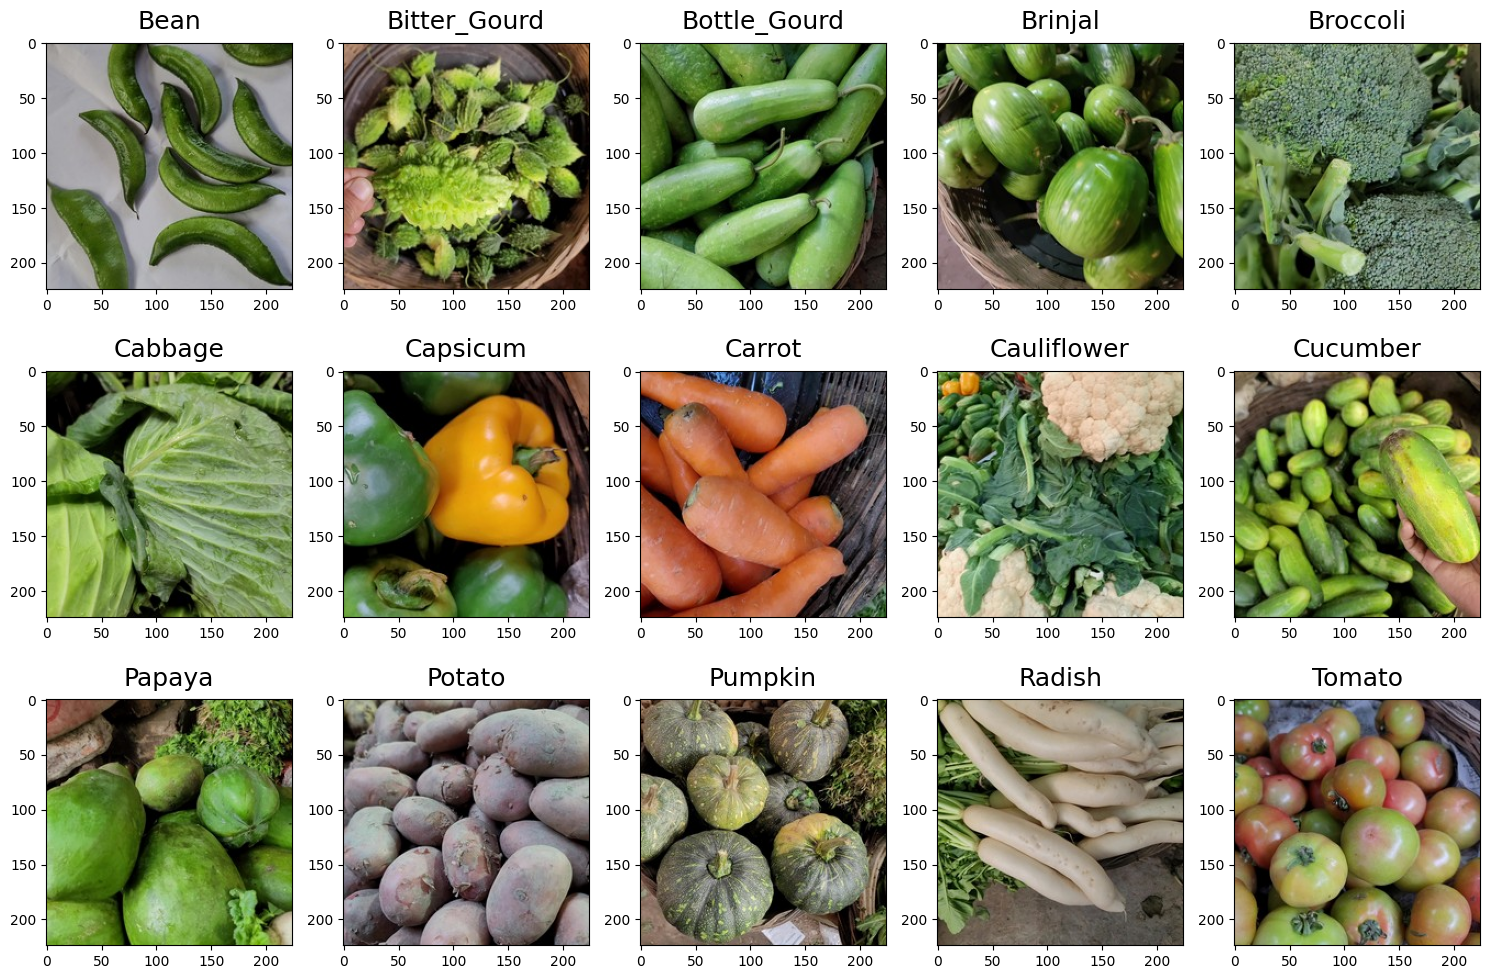

In [21]:
images = []

for food_folder in sorted(train_df['labels'].unique()):
    food_items = train_df[train_df['labels'] == food_folder]['filepaths'].tolist()
    food_selected = np.random.choice(food_items)
    images.append(food_selected)

fig = plt.figure(1, figsize=(15, 10))

for subplot, image_ in enumerate(images):
    category = image_.split('/')[-2]
    imgs = plt.imread(image_)
    a, b, c = imgs.shape
    fig = plt.subplot(3, 5, subplot + 1)
    fig.set_title(category, pad=10, size=18)
    plt.imshow(imgs)

plt.tight_layout()

## Data Preprocessing

In [30]:
# Data Augmentation

def scalar(img):
        return img

def create_gens(train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(
        sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

    test_steps = ts_length // test_batch_size

    tr_gen = ImageDataGenerator(
        preprocessing_function=scalar,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )


    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Train Generator
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Validation Generator
    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # Test Generator
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 15000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.
Found 3000 validated image filenames belonging to 15 classes.


## Model Building

In [23]:
model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [24]:
model.trainable = False

In [26]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

In [27]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
history = model.fit(x= train_gen,
                    epochs= 20,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

## Model Prediction

In [ ]:
history_df=pd.DataFrame(history.history)
history_df

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

In [ ]:
y_test =test_gen.classes
predictions = model.predict(test_gen)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

In [ ]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM